# 3. CART Decision Trees

This notebook will show different examples of CART decision trees.
The dataset used for them is [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) challenge from Kaggle. It contains about 10 years of daily weather observations from many locations across Australia. 

### Index:
1. [Packages required](#1.-Packages-required)
2. [Loading data](#2.-Loading-data)
3. [Example 1](#3.-Example-1)
4. [Example 2](#4.-Example-2)
5. [Printing tex table](5#.-Printing-tex-table)

# 1. Packages required

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

# 2. Loading data

In [2]:
weather = pd.read_parquet('../data/04_model_input/master.parquet')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Location.Walpole,Location.Hobart,Location.Launceston,Location.AliceSprings,Location.Darwin,Location.Katherine,Location.Uluru,WindGustDir_encoded,WindDir9am_encoded,WindDir3pm_encoded
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,0,0,0,0,0,0,0,12.0,12.0,13.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,0,0,0,0,0,0,0,13.0,15.0,11.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,0,0,0,0,0,0,0,11.0,12.0,11.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,0,0,0,0,0,0,0,2.0,6.0,4.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,0,0,0,0,0,0,0,12.0,3.0,14.0


# 3. Example 1

We are interested in show how is, graphically, a decision tree. We build one focus on predict 'RainTomorrow' with only two dependent variables (to graph it) and with maximum depth equals to 3. The dependent variables we will choose are: 'Humidity3pm' and 'Cloud3pm'.

We will choose train/test data according to an Out-Of-Time validation, with the purpose of knowing how well it works when the task is predict future values.

In [3]:
#We fix the variables we are interested in and the date to separate data:
test_date = '2015-01-01'
model_columns = ['Humidity3pm', 'Cloud3pm']

In [4]:
#We separate in train/test data and solve Nan problems:
train = weather[weather.Date < test_date].fillna(-1)
test = weather[weather.Date >= test_date].fillna(-1)

In [7]:
#We generate our decision tree for classification:
model_tree = DecisionTreeClassifier(max_depth = 2)
model_tree.fit(train[model_columns],train.RainTomorrow)

DecisionTreeClassifier(max_depth=2)

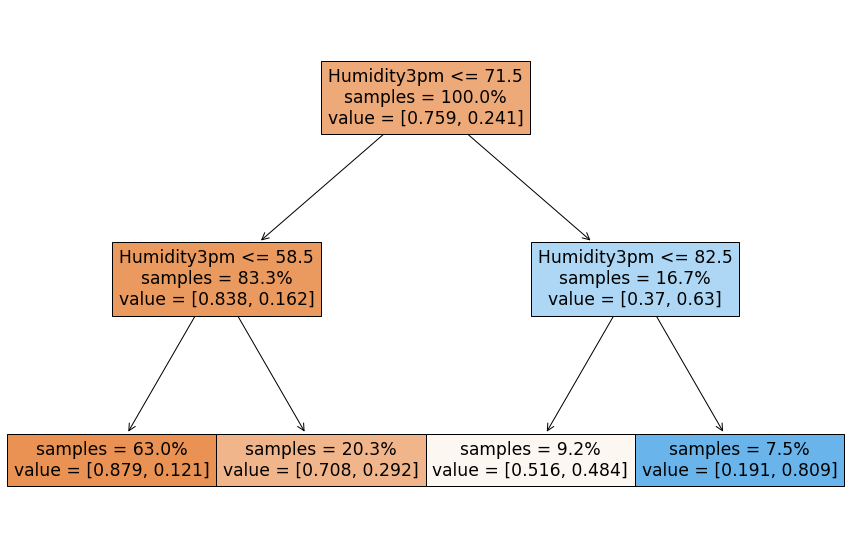

In [17]:
plt.figure(figsize = (15, 10))
plot_tree(model_tree, feature_names = model_columns, filled = True, impurity = False, proportion = True);

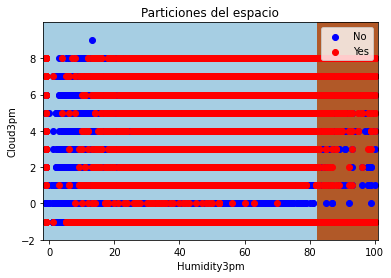

In [14]:
x_ex1 = weather[model_columns].fillna(-1)
y_ex1 = weather.RainTomorrow

n_classes = 2
plot_colors = 'br'
plot_step = 0.02

x_min, x_max = x_ex1['Humidity3pm'].min() - 1, x_ex1['Humidity3pm'].max() + 1
y_min, y_max = x_ex1['Cloud3pm'].min() - 1, x_ex1['Cloud3pm'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

z = model_tree.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)
cs = plt.contourf(xx, yy, z, cmap = plt.cm.Paired)

plt.xlabel('Humidity3pm')
plt.ylabel('Cloud3pm')
plt.axis('tight')

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_ex1 == i)[0]
    x_graph = []
    y_graph = []
    for j in idx:
        x_graph += [x_ex1.Humidity3pm.iloc[j]]
        y_graph += [x_ex1.Cloud3pm.iloc[j]]
        
    plt.scatter(x_graph, y_graph, c = color, label = ['No', 'Yes'][i] , cmap = plt.cm.Paired)
    
plt.axis('tight')
    
plt.title('Particiones del espacio')
plt.legend(loc = 'upper right')
plt.show()

# 4. Example 2

Now, we are interested in building a decision tree focus on predict 'RainTomorrow' based in all available variables. We will use train/test data from the last example.

Also, we will compare the result with different max_depth values to conclude which is the optimal value.

In [15]:
#We fix the variables we are interested in and the date to separate data:
test_date = '2015-01-01'

model_columns = list(set(weather.select_dtypes(include='number').columns) - set(['RainTomorrow']))

In [16]:
#We separate in train/test data and solve Nan problems:
train = weather[weather.Date < test_date].fillna(-1)
test = weather[weather.Date >= test_date].fillna(-1)

In [17]:
#We generate our decision trees:
metrics = {}
for max_depth in [1, 3, 5, 10, 15, 20, 30]:
    start_time = time.time()
    model = DecisionTreeClassifier(max_depth = max_depth)
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['DT_'+ str(max_depth)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time,
    }

metrics_pd = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_pd['delta%'] = 100*(metrics_pd.Test_Gini - metrics_pd.Train_Gini) / metrics_pd.Train_Gini
metrics_pd

,Run_Time,Train_Gini,Test_Gini,delta%
DT_1,0.281579,0.356810,0.324403,-9.082368
DT_3,0.436356,0.576891,0.564835,-2.089953
DT_5,0.704568,0.655905,0.628047,-4.247221
DT_10,1.180279,0.770627,0.604319,-21.580894
DT_15,1.792843,0.906248,0.438515,-51.611995
DT_20,1.973215,0.983012,0.317616,-67.689528
DT_30,2.318780,0.999920,0.362719,-63.725250


In [11]:
metrics_pd.to_parquet('../data/models/cart.parquet')

Let's see the difference between $Train\_Gini$ and $Test\_Gini$ evolution:

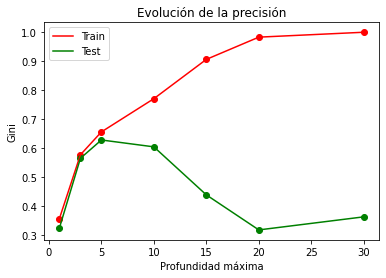

In [18]:
x = [1, 3, 5, 10, 15, 20, 30]
GINITRAIN = list(metrics_pd.Train_Gini)
GINITEST = list(metrics_pd.Test_Gini)

plt.plot(x, GINITRAIN, c = 'red', label = 'Train')
plt.scatter(x, GINITRAIN, c = 'red')
plt.plot(x, GINITEST, c = 'green', label = 'Test')
plt.scatter(x, GINITEST, c = 'green')
plt.xlabel('Profundidad máxima')
plt.ylabel('Gini')
plt.title('Evolución de la precisión')
plt.legend(loc = 'best')
plt.show()

# 5. Printing tex table

In [6]:
metrics2 = pd.read_parquet('../data/models/cart.parquet')
metrics2['Run_Time'] = round(metrics2.Run_Time, 1)
metrics2['Train_Gini%'] = np.where(metrics2.Train_Gini != None, round(100*metrics2.Train_Gini, 0), 0)
metrics2['Test_Gini%'] = np.where(metrics2.Test_Gini != None, round(100*metrics2.Test_Gini, 0), 0)
metrics2['delta%'] = round(metrics2['delta%'], 0)
metrics2[['Run_Time', 'Train_Gini%', 'Test_Gini%', 'delta%']]

,Run_Time,Train_Gini%,Test_Gini%,delta%
DT_1,0.3,36.0,32.0,-9.0
DT_3,0.5,58.0,56.0,-2.0
DT_5,0.7,66.0,63.0,-4.0
DT_10,1.2,77.0,61.0,-21.0
DT_15,1.7,91.0,43.0,-52.0
DT_20,2.1,98.0,31.0,-68.0
DT_30,2.1,100.0,36.0,-64.0


In [7]:
metrics2.to_parquet('../data/models/cart2.parquet')